# Submission Nicolo Lüscher

In [332]:
from skimage import io, color, feature, transform
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

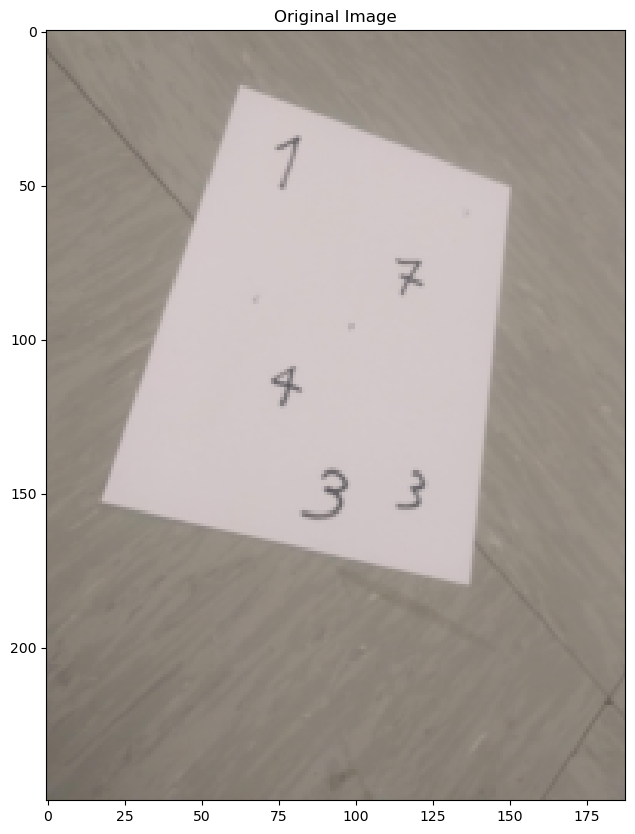

In [333]:
im = io.imread('images/homework images vol 1/IMG_20190312_183841.jpg')
# resize image
image = transform.resize(im, (250, 250*(im.shape[1]/im.shape[0])), anti_aliasing=True)
plt.title('Original Image')
plt.imshow(image)
plt.show()

In [334]:
gray_image = color.rgb2gray(image)
blurred_image = gaussian(gray_image, sigma=5)

thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > thresh

imedges = feature.canny(binary_image, sigma=1)

In [335]:
# Perform Hough transform
H, angles, distances = transform.hough_line(imedges)

# Find the indices of the top 20 highest values in H
k = 20
flattened_indices = np.argpartition(H.ravel(), -k)[-k:]
indices_2D = np.unravel_index(flattened_indices, H.shape)

# Extract and sort the corresponding distances and angles
distances_max = distances[indices_2D[0]]
angles_max = angles[indices_2D[1]]
sorted_indices = np.argsort(H[indices_2D])[::-1]
distances_max = distances_max[sorted_indices]
angles_max = angles_max[sorted_indices]

# Initialize lists to store accepted distances and angles
accepted_distances = []
accepted_angles = []

# Set thresholds for filtering lines
distance_threshold = 50  # pixels
angle_threshold = 0.2  # radians

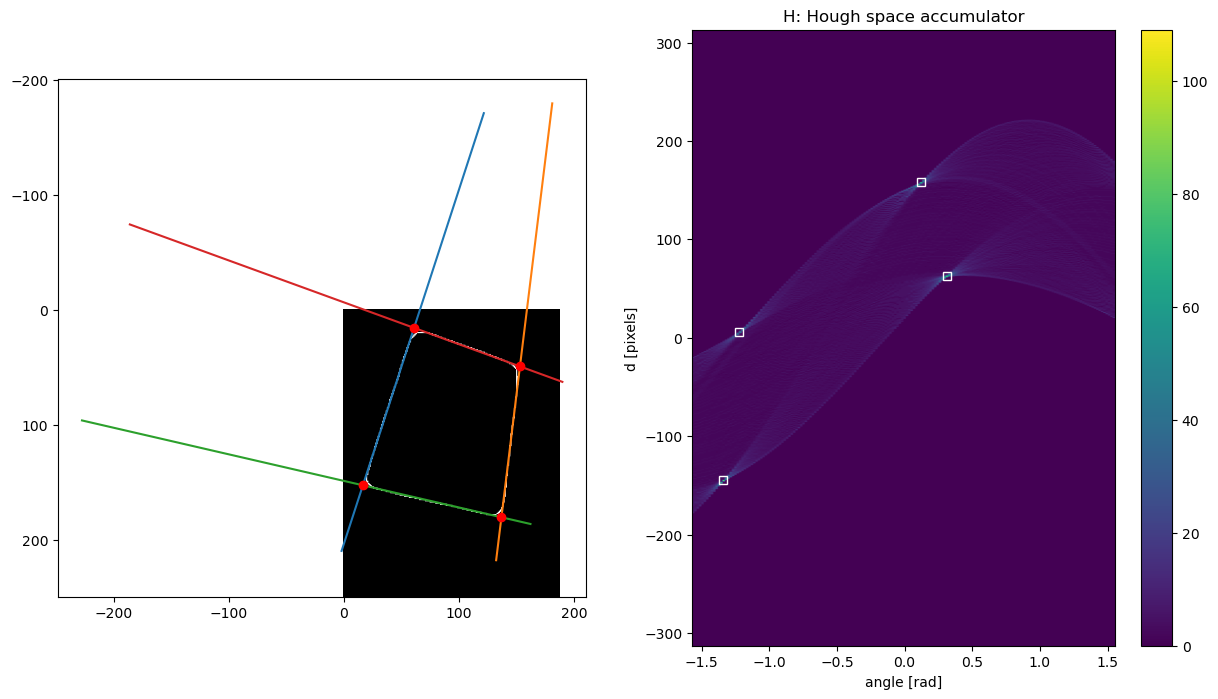

In [336]:
# Plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H, extent=(angles[0], angles[-1], distances[0], distances[-1]), origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]", ylabel="d [pixels]", title="H: Hough space accumulator")
plt.colorbar(Himage)

# Loop through the sorted highest values and filter lines
for i in range(k):
    d = distances_max[i]
    theta = angles_max[i]
    
    # Check if the line is too close or parallel to already accepted lines
    if len(accepted_distances) > 0:
        if any(np.abs(d - np.array(accepted_distances)) < distance_threshold) and any(np.abs(theta - np.array(accepted_angles)) < angle_threshold):
            continue
    
    # Add the line to the list of accepted lines
    accepted_distances.append(d)
    accepted_angles.append(theta)
    
    # Plot a white rectangle over the maximum in Hough space
    ax1.plot(theta, d, "ws", fillstyle="none")
    
    # Draw the line in image space
    p1 = np.array([d * np.cos(theta), d * np.sin(theta)])
    linedir = np.array([np.cos(theta + np.pi / 2), np.sin(theta + np.pi / 2)])
    p0 = p1 - linedir * 200
    p2 = p1 + linedir * 200
    ax0.plot([p0[0], p2[0]], [p0[1], p2[1]], scalex=False, scaley=False)

# Initialize list to store intersection points
intersections = []

# Loop through all pairs of lines to find intersections
for i in range(len(accepted_distances)):
    for j in range(i + 1, len(accepted_distances)):
        d1, theta1 = accepted_distances[i], accepted_angles[i]
        d2, theta2 = accepted_distances[j], accepted_angles[j]
        
        # Direction vectors
        dir1 = np.array([np.cos(theta1 + np.pi / 2), np.sin(theta1 + np.pi / 2)])
        dir2 = np.array([np.cos(theta2 + np.pi / 2), np.sin(theta2 + np.pi / 2)])
        
        # Points on the lines
        p1 = np.array([d1 * np.cos(theta1), d1 * np.sin(theta1)])
        p2 = np.array([d2 * np.cos(theta2), d2 * np.sin(theta2)])
        
        # Solve for intersection
        A = np.vstack([dir1, -dir2]).T
        b = p2 - p1
        if np.linalg.matrix_rank(A) == 2:  # Lines are not parallel
            t, s = np.linalg.solve(A, b)
            intersection = p1 + t * dir1
            intersections.append(intersection)

# Get the dimensions of the image
height, width = imedges.shape

# Filter intersections that are within the image dimensions
intersections = [point for point in intersections if 0 <= point[0] < width and 0 <= point[1] < height]

# Plot intersections on the image
for intersection in intersections:
    ax0.plot(intersection[0], intersection[1], 'ro')

plt.show()

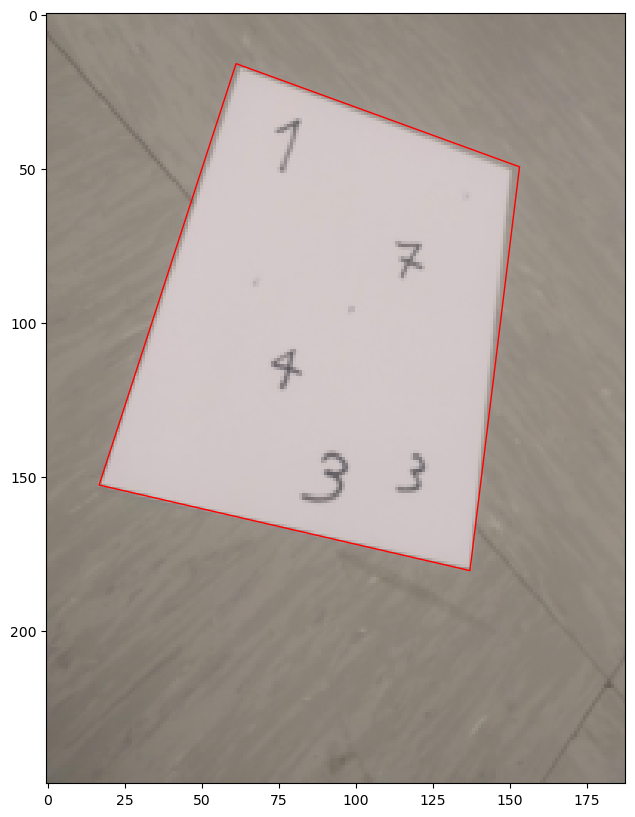

In [337]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Calculate the centroid
centroid = np.mean(intersections, axis=0)

# Sort the points based on the angle with the centroid
sorted_points = sorted(intersections, key=lambda point: np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))

# Create a Rectangle patch
rect = patches.Polygon(sorted_points, closed=True, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

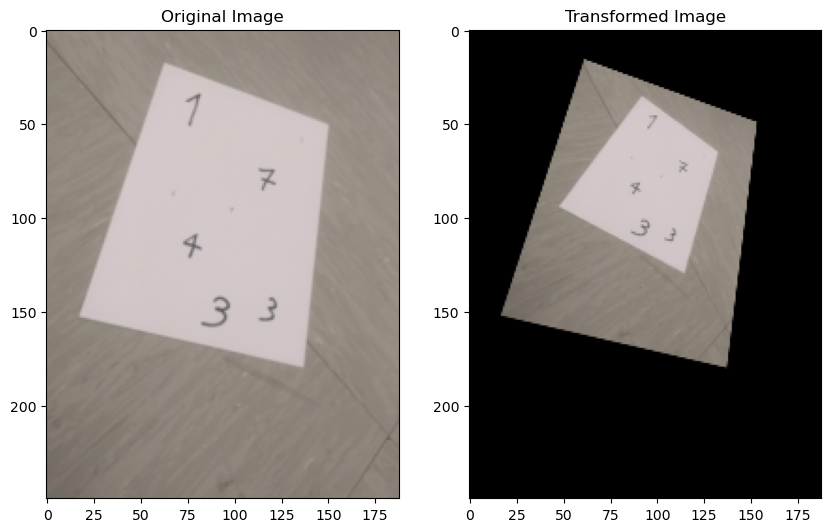

In [338]:
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]])

projective_transform = transform.ProjectiveTransform()
projective_transform.estimate(sorted_points, dst_points)

warped_image = transform.warp(image, projective_transform, output_shape=(height, width))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(warped_image)
plt.title('Transformed Image')

plt.show()
